Introduction to wavelet theory
=========

Author's Note:
---------------
I use this notebook to keep notes about my learning process about wavelet theory. I hope that these notes may help somebody else in their learning process, but as I am not an expert myself, they may of course contain erros. If you spot such an error, please let me know. 

What is a wavelet?
---------------
So... what exactly are these "wavelets" everybody is talking about? Well, just as a piglet is a small pig, a wavelet is - essentially - a small wave. A very simple example of such small wave is the mexican hat function:

$$m(x) = \frac{2}{\sqrt{3 \sigma} \pi^{\frac{1}{4}}} \left(1-\frac{x^2}{\sigma^2}\right) e^{\frac{-x^2}{2 \sigma^2}}$$

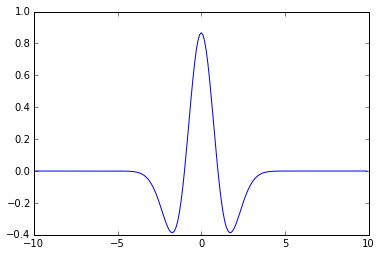

In [22]:
%matplotlib inline
# we will use numpy and matplotlib for all the following examples
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def mexican_hat(x, mu, sigma):
    return 2 / (np.sqrt(3 * sigma) * np.pi**0.25) * (1 - x**2 / sigma**2) * np.exp(-x**2 / (2 * sigma**2) )

xvals = np.arange(-10,10,0.1)
plt.plot(xvals, mexican_hat(xvals, 0, 1))
plt.show()

The mexican hat function/wavelet is the rescaled negative second derivative of the gaussian function (the probability distribution function of the normal distribution).

$$
g(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{\frac{- (x-mu)^2}{2 \sigma^2}}
$$

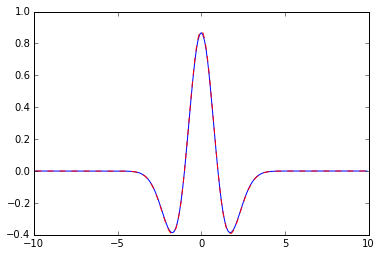

In [23]:
def gauss(x, mu, sigma):
    return 1.0 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))

g = gauss(xvals, 0, 1)
m = mexican_hat(xvals, 0, 1)
dg = g[1:] - g[:-1] # linear approximation of first derivative
ddg = dg[1:] - dg[:-1] # linear approximation of second derivative

plt.plot(xvals, m, "b-")
fac = m[len(xvals)//2] / -ddg[len(xvals)//2] # scaling factor
plt.plot(xvals[1:-1], -ddg*fac, "r--")
plt.show()

In fact, there are no theoretical limitations to what a wavelet can be. However, for practical purposes, "standard" wavelets, like the mexican hat wavelet, have some desirable properties.
* The integral of a wavelet should be finite.
* For the mexican hat wavelet, the integral is even zero, which means that a convolution with this function will leave the output signal in the same value range as the input signal.

In [6]:
np.sum(m)

0.0

Wavelet theory and the Fourier transform
-----------------------

The wavelet transform is often linked to the fourier transform, because both are used to inspect the frequency spectrum of a signal.
Using "small" waves instead of sine- and cosine-waves as in the Fourier transfom gives the additional benefit that spacial information is retained.

This difference between the wavelet transform and the fourier transform can be illustrated by looking at the result of the convolution of an artificial audio signal with a sine-wave compared to a convolution with a mexican hat wavelet:

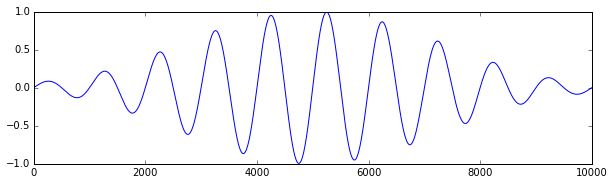

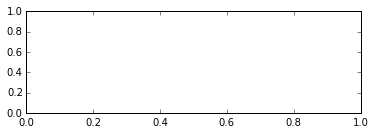

In [26]:
def hamming(n):
    """ Hamming window of size N for smoothing the edges of sound waves """
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(n) / (n-1))

def sound(freq, dur, res=10000):
    ln = dur*res
    sound = np.zeros(ln)
    sound = np.sin(np.arange(ln)*2*np.pi*freq/res)
    return sound * hamming(ln)

audio = np.zeros(100000)
audio[10000:20000] = sound(10,1)
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(sound(10,1))
plt.show()
plt.subplot(212)


#signal = np.zeros(10)
#signal[::2] = 1
#signal = np.repeat(signal,10)
#plt.subplot(121)
#plt.plot(signal)
#plt.ylim(0,2)
#plt.subplot(122)
#plt.plot(np.fft.fftfreq(len(signal)), np.abs(np.fft.fft(signal)))
#plt.show()

#revsig = np.zeros(100)
#revsig[45] = 1
#revsig[40] = 1
#plt.plot(np.abs(np.fft.ifft(revsig)))
#plt.show()
